In [180]:
from math import cos, log10, sin
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp
import types

In [351]:
#начальные данные метода
# A = [
#     [0,       0,        0,       0],
#     [12/23,   0,        0,       0],
#     [-68/375, 368/375,  0,       0],
#     [31/144,  529/1152, 125/384, 0]
# ]
# b = [0.21527777777777768, 0.45920138888888895, 0.32552083333333337, 0]

# c = [0, 12/23, 4/5, 1]

A=[[0,0,0],[1/2,0,0],[-1,2,0]]
b=[1/6,4/6,1/6]
c=[0,1/2,1]


#RK_method_params
    # RK_param_e = [1/2, 1/2, 1]
    # RK_param_c = [0, 1/2, 1/2, 1]
    # RK_param_b = [1/6, 1/3, 1/3, 1/6]
    # RK_param_a = [[], [1/2], [0, 1/2], [0, 0, 1]]

# c = [0, 1/2, 1/2, 1]
# b = [1/6, 1/3, 1/3, 1/6]
# A=[
#     [0,       0,        0,       0],
#     [1/2,   0,        0,       0],
#     [0, 1/2,  0,       0],
#     [0,  0, 1, 0]
# ]

s=len(A)
n=4 #желаемый порядок

In [400]:
class RK_method:
    def __init__(self, A, b, c, n=None):
        self.A = A
        self.b = b
        self.c = c
        self.n = n if n else len(A)
        self.s=len(A)
        self.E=1e-15
        self.method_param_check()
        self.b_teta=None
        


    def method_param_check(self):
        assert self.n<=self.s, "incorrect method data. Check n"
        assert self.s==len(self.b) and self.s==len(self.c), "incorrect method data. Check the dimensions of vectors and matrices"
        assert abs(sum(self.b)-1.0)<=self.E, f"incorrect method data. sum(b)={sum(self.b)}!=1"

        for i in range(self.s):
            assert len(self.A[i])==self.s, "incorrect method data. Check the dimensions of vectors and matrices"
            assert abs(sum(self.A[i])-self.c[i])<=self.E, f"incorrect method data. sum(A[{i}])!=c[{i}]."
        for i in range(self.s):
            for j in range(i, self.s):
                assert self.A[i][j]==0, f"incorrect method data.A[{i}][{j}]={self.A[i][j]}!=0.The explicit method implies a triangular matrix A"
    
    def set_b_teta(self, b_teta):
        for b in b_teta:
            assert b(1).isdigit(), "b_theta shuld be an array of functions"
        self.b_teta=b_teta
    
    def b_teta_calc(self):
        teta = sp.Symbol('teta')
        b_roots=[sp.Symbol(f'b{i}') for i in range(len(b))]
        sysEq=[sum(b_roots)-teta, 
            
                sum([b_roots[i]*c[i] for i in range(1,self.s)])-teta**2/2, 

                sum([b_roots[i]*c[i]**2 for i in range(1,self.s)])-teta**3/3,
                sum([b_roots[i]*sum([A[i][j]*c[j] for j in range(i)]) for i in range(self.s)])-teta**3/6,

                sum([b_roots[i]*c[i]**3 for i in range(1,self.s)])-teta**4/4,
                sum([b_roots[i]*c[i]*sum([A[i][j]*c[j] for j in range(i)]) for i in range(self.s)])-teta**4/8,
                sum([b_roots[i]*sum([A[i][j]*c[j]**2 for j in range(i)]) for i in range(self.s)])-teta**4/12,
                sum([b_roots[i]*sum([A[i][j]*sum([A[j][k]*c[k] for k in range(j)]) for j in range(i)]) for i in range(self.s)])-teta**4/24,
                ]
        
        assert self.n<=4, 'cant calculate for n>4. Use set_b_teta(self, b_teta)'
        if(self.n==1):
            sysEq=sysEq[0]
        if(self.n==2):
            sysEq=sysEq[0:2]
        if(self.n==3):
            sysEq=sysEq[0:4]
            for j in range(1,3):
                sysEq[-1]=sysEq[-1].subs(teta,1)
                for i in range(self.n):
                    sysEq[-1]=sysEq[-1].subs(b_roots[i],b[i])
                if(abs(sysEq[-1])<self.E):sysEq=sysEq[0:-1]
                else: print('не удовлетворяет необходимому условию порядка', sysEq[-1])
        if(self.n==4):
            sysEq=sysEq[0:4]
        sysEq=[sp.nsimplify(eq) for eq in sysEq]
        b_teta = sp.solve(sysEq)
        b_teta=[sp.nsimplify(sp.expand(b_teta[0][root])) for root in b_teta[0]]
        while(len(b_teta)<len(b)):
            b_missing=b[len(b_teta)]*teta**(self.n-1)
            b_teta=[b_.subs(b_roots[len(b_teta)],b_missing) for b_ in b_teta]
            b_teta.append(b_missing)
        self.b_teta=[eval("lambda teta:" + str(sp.nsimplify(root))) for root in b_teta]

    #решение DDE
    def get_solution_DDE(self, x0:float, x1:float, y0, f, h:float, tau:float):
        print('start')
        assert callable(f), "f(x,y)-eq for sol"
        assert x0+h<x1, "x0-start of sol, x1-end, h-step. It shouldnt be x0+h>x1"
        assert callable(y0), "f(x,y)-eq for sol"
        if(not self.b_teta):
            print('need some time for find b_teta')
            self.b_teta_calc()
            print('done it. Starting to calculate solution')

        Y=[y0(x0)]
        X=[]
        K_history=[]    

        #поиск пары чисел в упорядоченном массиве, между которыми мог бы заключен x
        def BS(x):
            assert x<=X[-1], "cant solve eq with such dellay."
            low = 0
            high = len(X) - 1
            while low <= high:
                mid = (low + high) // 2
                midVal = X[mid]
                if mid+1<len(X) and (midVal < x and X[mid+1] > x):
                    return midVal, X[mid+1], mid+1
                if mid-1>=0 and (midVal > x and X[mid-1] < x):
                    return X[mid-1], midVal, mid
                if midVal > x:
                    high = mid - 1
                else:
                    low = mid + 1
            print('not found :(')
            print(X, x)
            return

        def y_tau(x, tau):
            x-=tau
            if x<x0:
                return y0(x) #предыстория (за рамками интервала)
            if x in X:
                return Y[X.index(x)] #искомый y уже был посчитан
            x_m_1, x_m, m = BS(x)
            tet = (x-x_m_1)/(x_m-x_m_1)
            return Y[m-1]+h*sum([K_history[m-1][i]*self.b_teta[i](tet) for i in range(self.s)]) #рассчет y


        def K(x,y,f, h, tau):
            K_i=[]
            for i in range(self.s):
                K_i.append(f(x+self.c[i]*h, y+h*sum([self.A[i][j]*K_i[j] for j in range(i)]), y_tau(x+self.c[i]*h, tau)))
            return K_i
        
        
        for x in np.arange(x0, x1, h):
            if(x+h>x1):
                h=abs(x1-x)
            X.append(x)
            K_history.append(K(x,Y[-1],f, h, tau))
            Y.append(Y[-1]+h*sum([self.b[i]*K_history[-1][i] for i in range(self.s)]))
        X.append(x1)
         
        return(X, Y)



    #решение ОДУ и СОДУ
    def get_solution(self, x0:float, x1:float, y0, f, h:float):
        assert callable(f), "f(x,y)-eq for sol"
        assert x0+h<x1, "x0-start of sol, x1-end, h-step. It shouldnt be x0+h>x1"
        if isinstance(y0,(list,np.ndarray)):
            y0=np.array(y0)
            def K(x,y,f, h):
                K_i=[]
                for i in range(self.s):
                    K_i.append(np.array(f(x+self.c[i]*h, y+h*sum([self.A[i][j]*K_i[j] for j in range(i)]))))
                return K_i
        else:
            if isinstance(y0,(int,float)):
                def K(x,y,f, h):
                    K_i=[]
                    for i in range(self.s):
                        K_i.append(f(x+self.c[i]*h, y+h*sum([self.A[i][j]*K_i[j] for j in range(i)])))
                    return K_i
            else: assert False, "y0 shold be list or np.ndarray if you are trying to get system solution. y0 shold be int or float if you are trying to get eq solution."

        Y=[y0]
        X=[]
        for x in np.arange(x0, x1, h):
            if(x+h>x1):
                h=abs(x1-x)
            X.append(x)
            K_i=K(x,Y[-1],f, h)
            Y.append(Y[-1]+h*sum([self.b[i]*K_i[i] for i in range(self.s)]))
        X.append(x1)
         
        return(X, Y)
    
    #сходимость для ОДУ и СОДУ
    def get_Graph_Conversation(self, x0:float, x1:float, y0, f, y1_true, tau=0, n=None):
        n = n if n else self.n
        Norm = []
        H = []
        for k in range(3, 9):
            h = 1 / (2 ** k)
            H.append(np.log10(h))
            if callable(y0):
                X,Y = self.get_solution_DDE(x0, x1, y0, f, h, tau)
            else:
                X,Y = self.get_solution(x0, x1, y0, f, h)
            
            if isinstance(y1_true,(list,np.ndarray)):
                Norm.append(np.log10(np.linalg.norm([Y[-1][i]-y1_true[i] for i in range(self.s)])))
            else:
                Norm.append(np.log10(abs(Y[-1]-y1_true)))
        print('H:', H)
        print('Norm:', Norm)
        x = np.linspace(0,0.06,100)
        y = (Norm[0]) + n*(H-H[0])
        fig, ax = plt.subplots()
        ax.plot(H, Norm, color='b', linestyle='--')
        ax.plot(H, y, 'r')
        plt.xlabel("log10(Длина шага)")
        plt.ylabel("log10(Норма погрешности)")
        return H, Norm


    


start
need some time for find b_teta
done it. Starting to calculate solution
3 3
start
start
start
start
start
start
H: [-0.9030899869919435, -1.2041199826559248, -1.505149978319906, -1.806179973983887, -2.1072099696478683, -2.4082399653118496]
Norm: [-3.9017371603448017, -4.80252520485871, -5.70449424927159, -6.607031345991713, -7.5098468277638615, -8.412800019324717]


([-0.9030899869919435,
  -1.2041199826559248,
  -1.505149978319906,
  -1.806179973983887,
  -2.1072099696478683,
  -2.4082399653118496],
 [-3.9017371603448017,
  -4.80252520485871,
  -5.70449424927159,
  -6.607031345991713,
  -7.5098468277638615,
  -8.412800019324717])

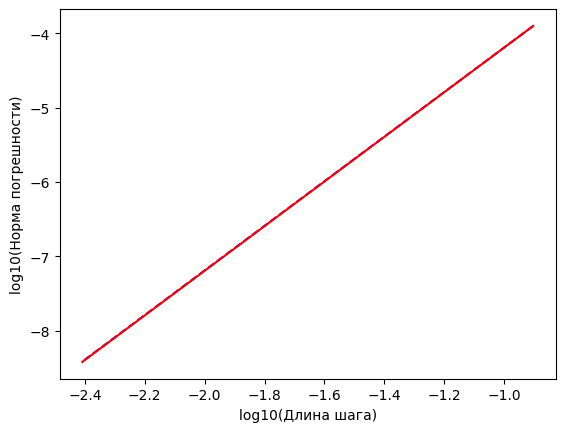

In [401]:
A=[[0,0,0],[1/2,0,0],[-1,2,0]]
b=[1/6,4/6,1/6]
c=[0,1/2,1]
x0=0
x1=2
def y0(t):
    return np.exp(t)
def f(x,y, y_tau):
    return np.exp(1)*y_tau
RK_method1=RK_method(A,b,c)
X,Y = RK_method1.get_solution_DDE(x0,x1,y0,f,(1/2)**6, 1)
RK_method1.get_Graph_Conversation(x0,x1, y0, f, np.exp(x1), 1)



In [366]:
A=[[0,0,0],[1/2,0,0],[-1,2,0]]
b=[1/6,4/6,1/6]
c=[0,1/2,1]
x0=0
x1=3
y0=1.5
RK_method1=RK_method(A,b,c)
def f(x,y):
    return -2*(y - np.cos(3*x))
def y_true(x):
    return 4/13 * np.cos(3*x)+6/13 * np.sin(3*x)+31/26 * np.exp(-2*x)
X,Y = RK_method1.get_solution(x0,x1,y0,f,(1/2)**6)
# RK_method1.get_Graph_Conversation(x0,x1,y0,f,y_true(x1))


H: [-1.505149978319906, -1.806179973983887, -2.1072099696478683, -2.4082399653118496, -2.709269960975831, -3.010299956639812, -3.3113299523037933, -3.612359947967774, -3.9133899436317554]
Norm: [-0.8665328011406246, -1.7168855501441642, -2.5980988761243133, -3.491296314493273, -4.389724059326389, -5.2905578542927625, -6.192539126796104, -7.095083389931203, -7.997836644569729]


([-1.505149978319906,
  -1.806179973983887,
  -2.1072099696478683,
  -2.4082399653118496,
  -2.709269960975831,
  -3.010299956639812,
  -3.3113299523037933,
  -3.612359947967774,
  -3.9133899436317554],
 [-0.8665328011406246,
  -1.7168855501441642,
  -2.5980988761243133,
  -3.491296314493273,
  -4.389724059326389,
  -5.2905578542927625,
  -6.192539126796104,
  -7.095083389931203,
  -7.997836644569729])

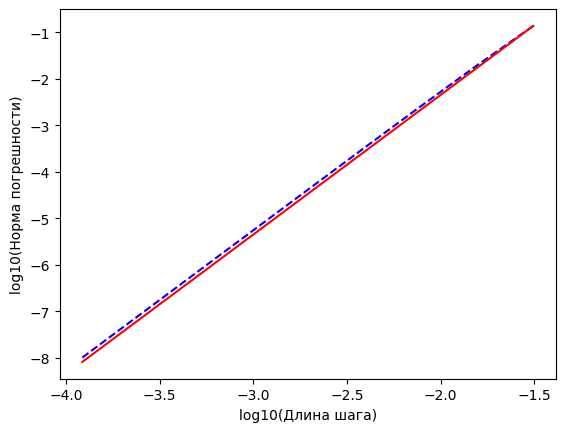

In [367]:
A = 3
B = 1.5
C = -1
x0 = 0
x1 = 5
y0 = [1, 1, A, 1]
def f_mean(x: float, y: list):
    return [
        2 * x * (y[1] ** (1/B)) * y[3], 
        2 * B * x * np.exp((B / C) * (y[2] - A)) * y[3], 
        2 * C * x * y[3], 
        -2 * x * np.log(y[0])
    ]
def f_solution(x: float):
    return [
        np.exp( np.sin( x ** 2 ) ),
        np.exp( B * np.sin( x ** 2 ) ),
        C * np.sin( x ** 2 ) + A,
        np.cos( x ** 2 )
    ]

y_true = f_solution(x1)

RK_method1.get_Graph_Conversation(x0,x1,y0,f_mean,y_true)

In [ ]:
def binarySearch(x, arr):
        mid = len(arr) // 2
        low = 0
        high = len(arr) - 1

        while arr[mid] != x and low <= high:
            if x > arr[mid]:
                low = mid + 1
            else:
                high = mid - 1
            mid = (low + high) // 2

        return mid

class vide_solver:
    #RK_method_params
    # RK_param_e = [1/2, 1/2, 1]
    # RK_param_c = [0, 1/2, 1/2, 1]
    # RK_param_b = [1/6, 1/3, 1/3, 1/6]
    # RK_param_a = [[], [1/2], [0, 1/2], [0, 0, 1]]

    def __init__(self, K, f, limit=lambda x:0):
        self.K = K
        self.f = f
        self.low_integr_limit=limit


    def integration_K(self, t, X, Y, F):
        res = 0
        start = binarySearch(self.low_integr_limit(t), X)
        end = binarySearch(t, X)
        if start<0:
            if end<0:
                return (t-self.low_integr_limit(t))*Y[0]
            res+=(X[0]-self.low_integr_limit(t))*Y[0]
            start+=1
        elif self.low_integr_limit(t)!=X[start]:
            a = self.low_integr_limit(t)
            b = X[start + 1]
            h = b - a
            y_new=self.new_y(F[start], Y[start], h, (a-X[start])/(X[start+1]-X[start]))
            K_a = self.K(x=t, s=a, y=y_new)
            K_b = self.K(x=t, s=b, y=Y[start + 1])
            y_half_h = self.new_y(F[start], Y[start], h, (a+h/2-X[start])/(X[start+1]-X[start]))
            K_half_h = self.K(x=t, s=(a+b)/2, y=y_half_h)
            res += h/6*(K_a+4*K_half_h+K_b)
            start+=1
        

        for i in range(start, end):
            a = X[i]
            b = X[i + 1]
            h = b - a
            K_a = self.K(x=t, s=a, y=Y[i])
            K_b = self.K(x=t, s=b, y=Y[i + 1])
            y_half_h = self.new_y(F[i], Y[i], h, 1/2)
            K_half_h = self.K(x=t, s=(a+b)/2, y=y_half_h)
            res += h/6*(K_a+4*K_half_h+K_b)
        return res

    
    def b_param (self, teta):
        teta_2=teta*teta
        teta_3=teta_2*teta
        return [teta-3/2*teta_2+2/3*teta_3, teta_2-2/3*teta_3, teta_2-2/3*teta_3, 2/3*teta_3-teta_2/2]

    
    def Y_Z_f(self, h, X, Y, F_values):
        last_y=Y[-1]
        last_t=X[-1]
        step_const_x = last_t +1/2 * h
        F1=self.integration_K(last_t, X, Y, F_values)
        F=self.integration_K(step_const_x, X, Y, F_values)
        Y1 = last_y
        Z1=0
        f2=self.f(x=last_t, y=Y1, F_=F1+Z1)
        Y2=last_y+1/2*h*f2
        Z2=1/2*h*self.K(x=step_const_x, s=last_t, y=Y1)
        f3=self.f(x=step_const_x, y=Y2, F_=F+Z2)
        Y3=last_y+1/2*h*f3
        Z3=1/2*h*self.K(x=step_const_x, s=step_const_x, y=Y2)
        f4=self.f(x=step_const_x, y=Y3, F_=F+Z3)
        Y4=last_y+h*f4
        Z4=h*self.K(x=last_t +h, s=step_const_x, y=Y3)
        f_=[f2, 
            f3, 
            f4, 
            self.f(x=last_t+h, y=Y4, F_=self.integration_K(last_t+h, X, Y, F_values)+Z4)]
        return(f_)
    
    def new_y(self, f_, last_y, h, teta):
        RK_param_b=self.b_param(teta)
        return last_y+h*sum([f_[i]*RK_param_b[i] for i in range(4)])
    
    def RK_method(self, x0, x1, h, y0):
        X=[]
        Y=[]
        F=[]
        if isinstance(x0, list) and isinstance(y0, list):
            X.extend(x0)
            Y.extend(y0)
        else:  
            X.append(x0)
            Y.append(y0)
        while X[-1]+h<=x1:
            F.append(self.Y_Z_f(h, X, Y, F))
            Y.append(self.new_y(F[-1], Y[-1], h, 1))
            X.append(X[-1]+h)
        if X[-1]!=x1:
            F.append(self.Y_Z_f(x1-X[-1], X, Y, F))
            Y.append(self.new_y(F[-1], Y[-1], h, 1))
            X.append(x1)
        return(X,Y, F)
    
    
    def DiffrentsSteps(self, t, x0, y0):
        y_res=[]
        integ_res=[]
        H=[]
        for i in range(1, 9):
            h=1/(2**i)
            X,Y,F=self.RK_method(x0, t, h, y0)
            y_res.append(Y[-1])
            integ_res.append(self.integration_K(t, X, Y, F))
            H.append(log10(h))
        return(H, y_res, integ_res)
    
    def GraphConvDrow(self, estimated_convergence, H, Error):
        y = [Error[0] + estimated_convergence*(i-H[0]) for i in H]
        fig, ax = plt.subplots()
        ax.plot(H, Error, color='b', linestyle='--')
        ax.plot(H, y, 'r')
        plt.xlabel("log10(Длина шага)")
        plt.ylabel("log10(Норма полной погрешности)")
    
    def ConvCheck(self, estimated_convergence, solution_func, t, x0, y0):
        H_y_integration_res=self.DiffrentsSteps(t, x0, y0)
        true_sol_y_integ=[i(t) for i in solution_func]
        for i in range(len(solution_func)):
            error=[log10(abs(true_sol_y_integ[i]-j)) for j in H_y_integration_res[i+1]]
            self.GraphConvDrow(estimated_convergence, H_y_integration_res[0], error)

    def GraphSolution(self, t, x0, y0, h, analytical_solution=0):
        X,Y,F=self.RK_method(x0, t, h, y0)
        fig, ax = plt.subplots()
        if callable(analytical_solution):
            y = [analytical_solution(i) for i in X]
            ax.plot(X, y, 'r')
        ax.plot(X, Y, color='b', linestyle='--')
        plt.xlabel("x")
        plt.ylabel("y")
        return X,Y
